In [1]:
import os
import xml.etree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn
import mrcnn.visualize
import cv2


Using TensorFlow backend.


In [2]:
images_dir = 'F:/AI ML DL Projects/Supports/Mask-RCNN-TF2/custom_dataset/data/images'
files = os.listdir(images_dir)
print(len(files)/3*2)

132.0


In [3]:
class cropsDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        # Adds information (image ID, image path, and annotation file path) about each image in a dictionary.
        self.add_class("dataset", 1, "coconut")
        self.add_class("dataset", 2, "palm")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        files = os.listdir(images_dir)
        for filename in os.listdir(images_dir):
            image_id = filename[:-4]

            if is_train and int(image_id) >= len(files)/3*2:
                continue

            if not is_train and int(image_id) < len(files)/3*2:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # Loads the binary masks for an image.
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            if(box[4] == 'coconut'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('coconut'))
            if(box[4] == 'palm'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('palm'))
               
        return masks, asarray(class_ids, dtype='int32')

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//object'):
  
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']




In [4]:
# Train
train_dataset = cropsDataset()
train_dataset.load_dataset(dataset_dir='data', is_train=True)
train_dataset.prepare()
print('Train: %d' % len(train_dataset.image_ids))

Train: 131


In [5]:
# Validation
validation_dataset = cropsDataset()
validation_dataset.load_dataset(dataset_dir='data', is_train=False)
validation_dataset.prepare()
print('Test: %d' % len(validation_dataset.image_ids))

Test: 67


# Display sample images

In [12]:

import random
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

In [15]:

num=random.randint(0, len(train_dataset.image_ids))
# define image id
image_id = num
print(image_id)
# load the image
image = train_dataset.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_dataset.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_dataset.class_names)

74


FileNotFoundError: No such file: 'f:\AI ML DL Projects\Supports\Mask-RCNN-TF2\custom_dataset\data\images\075.jpg'

In [45]:
class CropConfig(mrcnn.config.Config):
    NAME = "crops_cfg"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE = 0.001
    NUM_CLASSES = 3
    EPOCH = 20
    STEPS_PER_EPOCH = 10
    IMAGE_SHAPE = (819,546,3)

In [46]:
# Model Configuration
crop_config = CropConfig()
crop_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCH                          20
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE     

In [47]:
ROOT_DIR = os.path.abspath("./")
DEFAULT_LOG_DIR = os.path.join(ROOT_DIR, 'logs')

In [57]:
# Build the Mask R-CNN Model Architecture
model = mrcnn.model.MaskRCNN(mode='training', 
                            model_dir=DEFAULT_LOG_DIR,
                            config=crop_config)

In [58]:
model.load_weights(filepath='weights/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [59]:
model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=crop_config.LEARNING_RATE, 
            epochs=crop_config.EPOCH, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /logdir/train\mask_rcnn_crops_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)

c:\Users\viran\anaconda3\envs\mask-rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
10/10 [==============================] - 740s 74s/step - loss: 5.2012 - val_loss: 3.1135
Epoch 2/20
10/10 [==============================] - 731s 73s/step - loss: 3.1097 - val_loss: 2.6308
Epoch 3/20
10/10 [==============================] - 832s 83s/step - loss: 2.9819 - val_loss: 2.2273
Epoch 4/20
10/10 [==============================] - 835s 84s/step - loss: 2.4309 - val_loss: 2.0258
Epoch 5/20
10/10 [==============================] - 826s 83s/step - loss: 2.2531 - val_loss: 2.1555
Epoch 6/20
10/10 [==============================] - 824s 82s/step - loss: 2.1979 - val_loss: 2.2856
Epoch 7/20
10/10 [==============================] - 834s 83s/step - loss: 2.0621 - val_loss: 1.7086
Epoch 8/20
10/10 [==============================] - 847s 85s/step - loss: 2.1520 - val_loss: 1.9507
Epoch 9/20
10/10 [==============================] - 807s 81s/step - loss: 1.9692 - val_loss: 1.9991
Epoch 10/20
10/10 [==============================] - 849s 85s/step - loss: 1.9471 - val_loss: 1.7218

In [60]:
model_path = 'crops_mask_rcnn_trained_01.h5'
model.keras_model.save_weights(model_path)

# Predict the data

In [61]:
from matplotlib.patches import Rectangle
import random

In [62]:
num = random.randint(0, len(train_dataset.image_ids))
image_id = num

In [66]:
iamge = train_dataset.load_image(image_id)
mask, class_ids = train_dataset.load_mask(image_id)
bbox = extract_bboxes(mask)

In [76]:

CLASS_NAMES = ['BG','coconut', 'palm']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "crops_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)


In [77]:
# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

In [78]:
os.getcwd()

'f:\\AI ML DL Projects\\Supports\\Mask-RCNN-TF2\\custom_dataset'

In [79]:
# Load the weights into the model.
model.load_weights(filepath="crops_mask_rcnn_trained_01.h5", 
                   by_name=True)

13


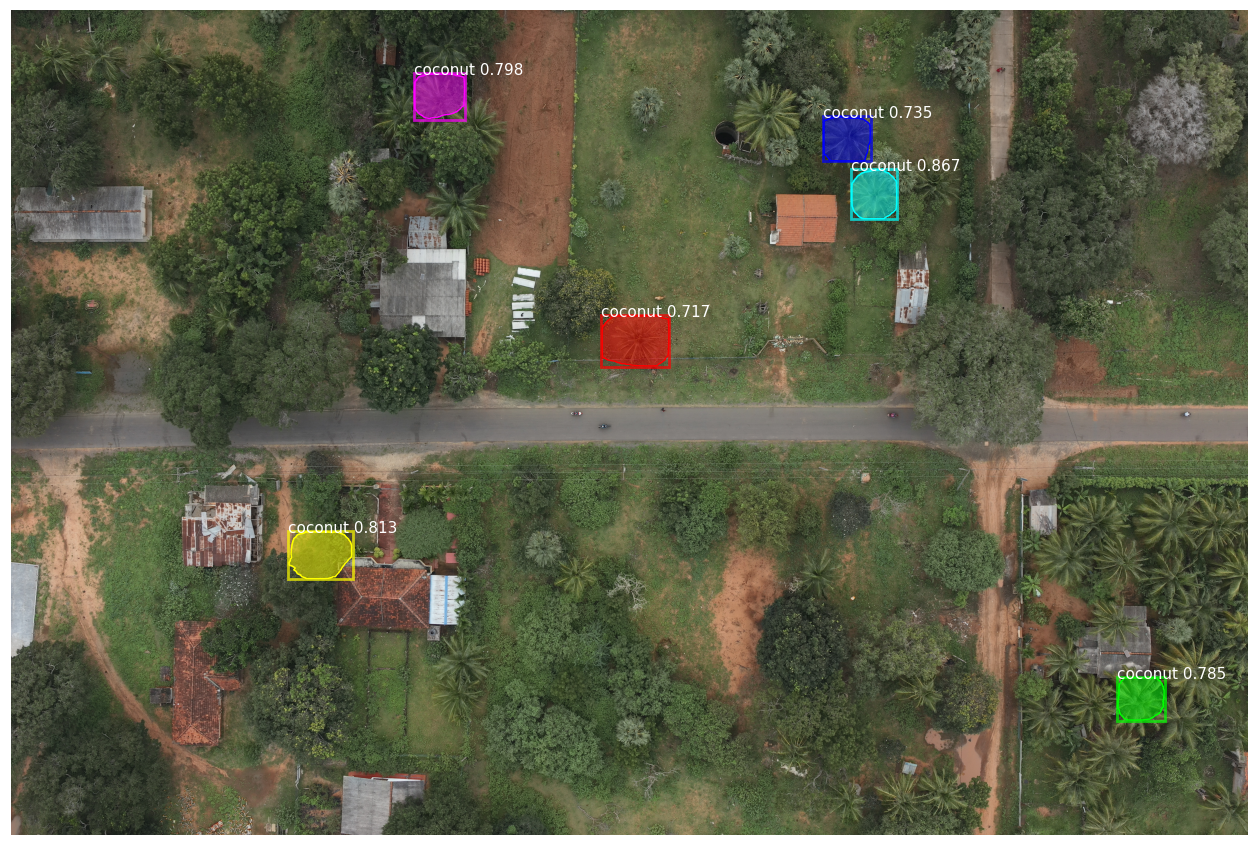

In [103]:
# load the input image, convert it from BGR to RGB channel
print(image_id)
image = cv2.imread("DJI_20221113120735_0053.JPG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])